In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
from skimage.io import imread, imshow
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
import keras.callbacks
from keras.callbacks import ModelCheckpoint
import random
from keras.applications import vgg16
from keras.preprocessing import image
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
train_dir = 'sickmushrooms_sources2/sickmushrooms_sources/seg_train'
test_dir = 'sickmushrooms_sources2/sickmushrooms_sources/seg_test'
# pred_dir = 'sickmushrooms_sources2/sickmushrooms_sources/seg_pred'

In [3]:
# 클래스 라벨 붙이기 
# 버섯 5종류 
class_names = ['oyster_blue','oyster_brown',
               'pleurotus_blue','pleurotus_brown','pleurotus_white',
               'portobello_blue', 'portobello_brown', 'portobello_white',
               'shiitake_blue','shiitake_brown','shiitake_white', 
               'winter_black', 'winter_blue', 'winter_white']

# oyster_brown 느타리_세균갈색무늬병
# oyster_blue 느타리_푸른곰팡이병
#pleurotus_blue 큰느타리_푸른곰팡이병
#pleurotus_brown 큰느타리_세균갈색무늬병
#pleurotus_white 큰느타리_흰곰팡이병
#portobello_blue 양송이_푸른곰팡이병
#portobello_brown 양송이_세균갈색무늬병
#portobello_white 양송이_솜털곰팡이병
#shiitake_blue 표고_푸른공팡이병
#shiitake_brown 표고_세균갈색무늬병
#shiitake_white 표고_흰곰팡이병
#winter_black 팽이_세균성검은썩음병
#winter_blue 팽이_푸른곰팡이병
#winter_white 팽이_흰곰팡이병


class_labels = {class_name:i for i, class_name in enumerate(class_names)}
print(class_labels)

number_classes = len(class_names)

IMAGE_SIZE = (150,150)

{'oyster_blue': 0, 'oyster_brown': 1, 'pleurotus_blue': 2, 'pleurotus_brown': 3, 'pleurotus_white': 4, 'portobello_blue': 5, 'portobello_brown': 6, 'portobello_white': 7, 'shiitake_blue': 8, 'shiitake_brown': 9, 'shiitake_white': 10, 'winter_black': 11, 'winter_blue': 12, 'winter_white': 13}


In [4]:
# os.listdir와 os.path 사용해 기능연결해서 train데이터 건수 확인

for folder in os.listdir(train_dir):
    files_path = []
    for file in os.listdir(os.path.join(train_dir,folder)):
        files_path.append(file)
    print(len(files_path)) 

# 팽이 흰털곰팡이병(winter_white)은 데이터가별로 없음(474건)

2066
2057
2112
2112
1827
2057
2075
2109
2102
1914
2142
1980
2067
474


# 데이터 로드

In [5]:
# load_dataset함수를 정의해 레이블과 함께 데이터셋 로드

def load_dataset():
    # create list of datasets
    datasets = [train_dir, test_dir]
    output = []
    
    for dataset in datasets:
        
        images1 = []
        labels1 = []
        print(f"loading {dataset}")
        
        for folder in os.listdir(dataset):
            # 각각의 이미지 폴더에 레이블 할당하기 
            label = class_labels[folder]
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                image_path = os.path.join(os.path.join(dataset, folder), file)
                # image_path에 저장된 이미지 파일 읽기
                image_file = cv2.imread(image_path)
                image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
                image_file = cv2.resize(image_file, IMAGE_SIZE)
                
                images1.append(image_file)
                labels1.append(label)
                
        # 이미지 및 레이블들을 numpy로 데이터 타입 변환합니다
        images1 = np.array(images1, dtype = 'float32')
        labels1 = np.array(labels1, dtype = 'int32')
        
        output.append((images1, labels1))
        print("Images file have been loaded")
                
    return output 


In [6]:
((train_images, train_labels), (test_images, test_labels)) = load_dataset()

loading sickmushrooms_sources2/sickmushrooms_sources/seg_train


100%|████████████████████████████████████████████████████████████████████████████████| 474/474 [00:08<00:00, 52.87it/s]


Images file have been loaded
loading sickmushrooms_sources2/sickmushrooms_sources/seg_test


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 55.78it/s]


Images file have been loaded


In [7]:
# train dataset 크기
print("train dataset size")
len(train_images), len(train_labels)

train dataset size


(27094, 27094)

In [8]:
# testdataset size
print("test dataset size")
len(test_images), len(test_labels)

test dataset size


(6698, 6698)

In [9]:
# 이미지 데이터 세트의 shape는 4차원
train_images.shape, test_images.shape

((27094, 150, 150, 3), (6698, 150, 150, 3))

In [10]:
# train 데이터셋과 test 데이터셋 섞기
(train_images, train_labels) = shuffle(train_images, train_labels, random_state=42)

In [11]:
(test_images, test_labels) = shuffle(test_images, test_labels, random_state=42)

In [12]:
# 훈련과 테스트 데이터들 12000개로 보관 
# 처음에는 그대로 실행했으나 시간이 오래 걸리고 정확도도 비슷해 절반정도로 줄임
train_images = train_images[:12000]
train_labels = train_labels[:12000]

In [13]:
test_images = test_images[:2800]
test_labels = test_labels[:2800]

In [14]:
# 이미지 데이터셋 정규화
trn_images_norm = train_images/255.0
tst_images_norm = test_images/255.0

# train과 test dataset 비율 시각화

In [15]:
def proportion_labels(labels, dataset):
    series = pd.DataFrame(labels).reset_index()
    series.rename(columns = {0:'labels'}, inplace=True)
    final_s = series.groupby('labels').count().reset_index()                                          
    ticks1= [key for key in class_labels.keys()]
    
    # plot the pie chart and bar graph of labels
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.bar(np.array(final_s['labels']), np.array(final_s['index']))
    plt.xticks(ticks=np.array(final_s['labels']), labels=ticks1, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.grid(visible=True)
    plt.title("Number of images per class", size=14, weight='bold')
    
    plt.subplot(122)
    plt.pie(final_s['index'].ravel(),
            labels=ticks1,
            autopct='%1.2f%%',
            textprops={'fontweight':'bold'}
           )
    plt.title("proportion of classes", size=14, weight='bold')
    
    plt.suptitle(f"Proportion of {dataset} data", size=20, weight='bold')
    plt.show()
    
    return final_s

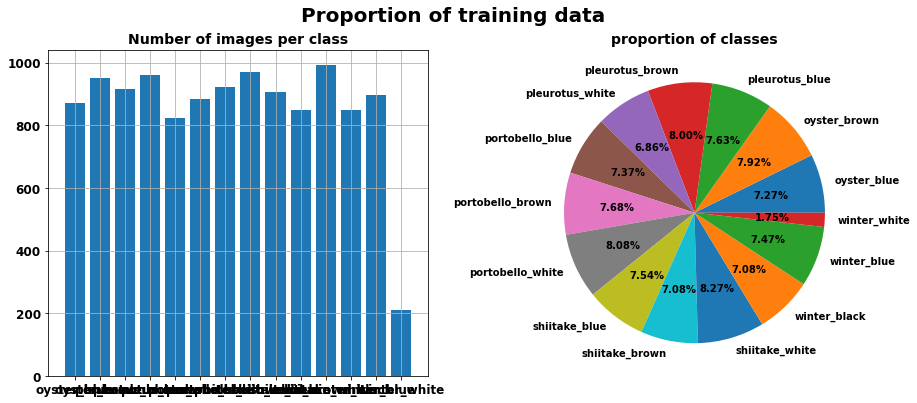

In [16]:
final_s = proportion_labels(train_labels, "training")

#winter_white 팽이_흰곰팡이병을 제외하고 다들 비슷하게 분포해 있다.

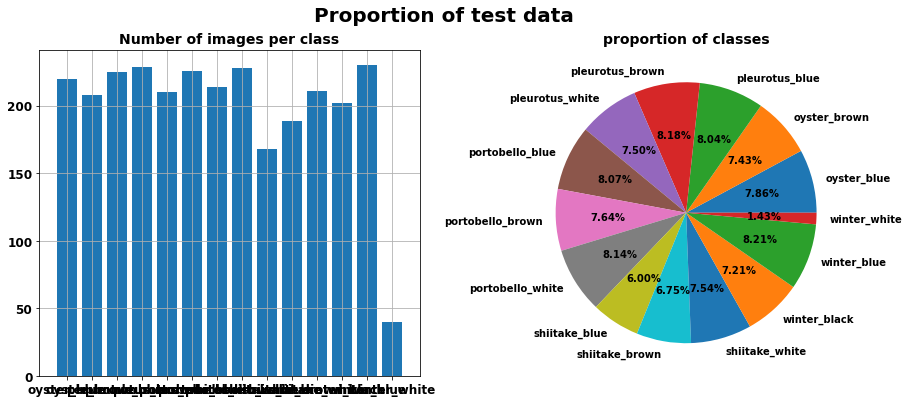

In [17]:
test_d = proportion_labels(test_labels, "test")

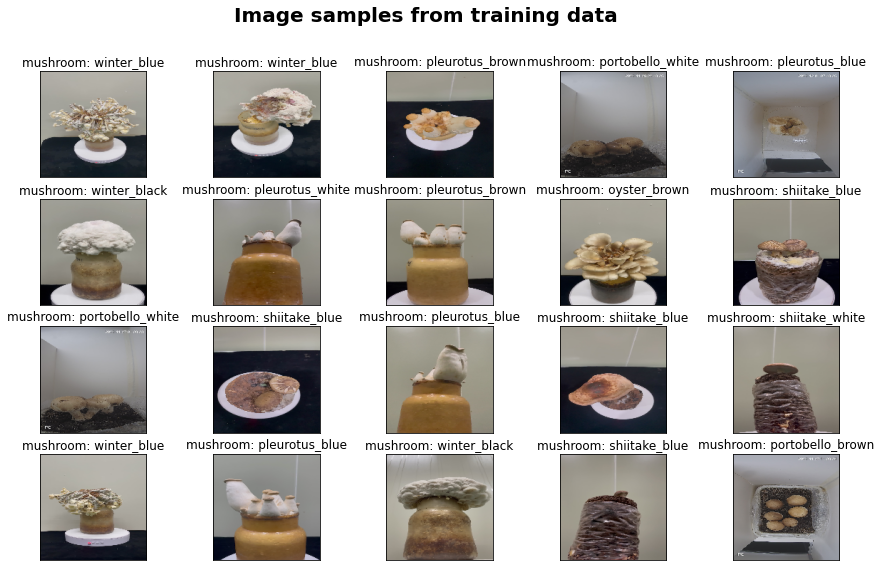

In [18]:
# training data에서 이미지 사진뽑아서  15장 확인
plt.figure(figsize=(15,9))
for idx, label in enumerate(train_labels[:20]):
    plt.subplot(4,5, idx+1)
    plt.imshow(trn_images_norm[idx])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'mushroom: {class_names[label]}')   
    
plt.suptitle(f'Image samples from training data', size=20, weight='bold')
plt.show()

# 모델 만들기

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(14, activation='softmax'))

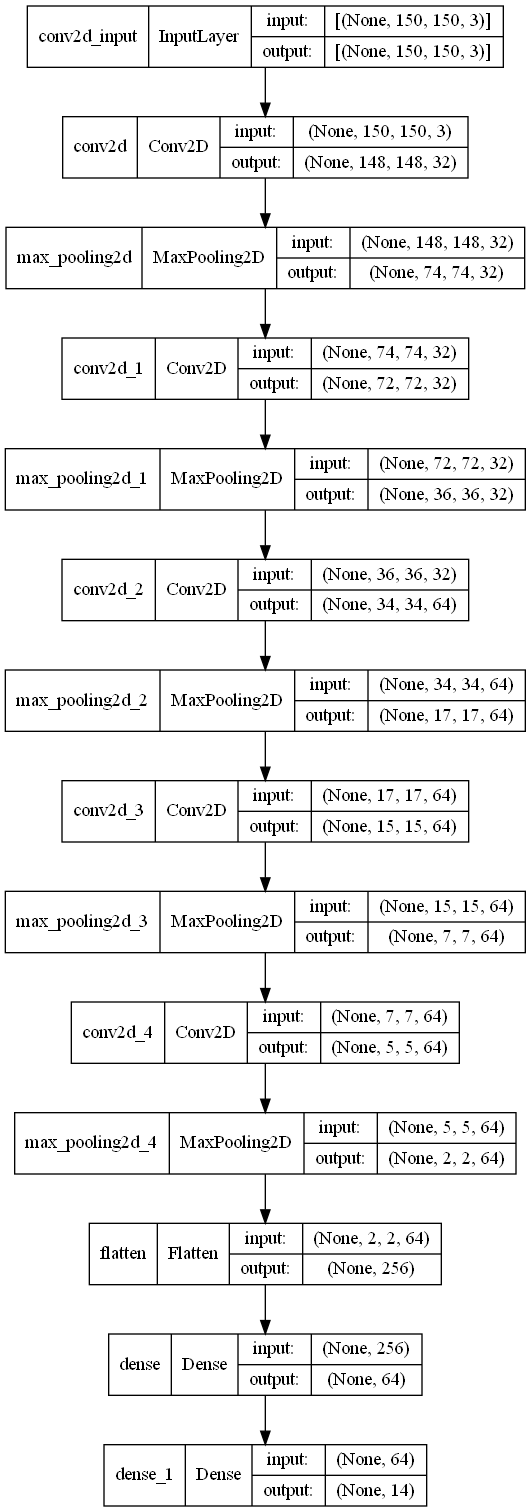

In [20]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [21]:
# 레이블을 categorical로 원핫인코딩
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# adam으로 모델 compile
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy']
             )

# early stopping 과 콜백함수(ModelCheckpoing:모델을 저장할 때 사용되는 콜백함수)
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
# val_loss가 더이상 감소되지 않을 경우 EarlyStopping을 적용
# mode=min monitor되는 값이 최소가 되어야 한다

checkpointer = ModelCheckpoint(filepath='bestvalue', verbose=0, save_best_only=True)
#verbose = 0 저장된다는 표시 없이 바로 저장. 
# save_best_only = True monitor 되고 있는 값을 기준으로 가장 좋은 값으로 모델이 저장

callback_list = [checkpointer, earlystopping]

In [22]:
# 데이터에 모델 fit 
# batch_size = 256으로 시도해보았으나 컴퓨터성능한계로 128로 줄임
history = model.fit(trn_images_norm, train_labels, batch_size=128, epochs=15, validation_data=(tst_images_norm, test_labels),
                   callbacks=callback_list)

# 모델 평가
test_loss, test_acc = model.evaluate(tst_images_norm, test_labels, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
94/94 [==============================] - 118s 1s/step - loss: 2.2813 - accuracy: 0.1998 - val_loss: 1.9465 - val_accuracy: 0.2714
Epoch 2/15
94/94 [==============================] - 105s 1s/step - loss: 1.2556 - accuracy: 0.5219 - val_loss: 1.7487 - val_accuracy: 0.3454
Epoch 3/15
94/94 [==============================] - 97s 1s/step - loss: 0.8715 - accuracy: 0.6553 - val_loss: 1.8107 - val_accuracy: 0.3889
Epoch 4/15
94/94 [==============================] - 97s 1s/step - loss: 0.6853 - accuracy: 0.7253 - val_loss: 1.8341 - val_accuracy: 0.3814
Epoch 5/15
94/94 [==============================] - 94s 1s/step - loss: 0.5604 - accuracy: 0.7782 - val_loss: 1.9065 - val_accuracy: 0.4275
Epoch 6/15
94/94 [==============================] - 101s 1s/step - loss: 0.4548 - accuracy: 0.8198 - val_loss: 2.0684 - val_accuracy: 0.4011
Epoch 7/15
94/94 [==============================] - 102s 1s/step - loss: 0.3937 - accuracy: 0.8455 - val_loss: 2.0477 - val_accuracy: 0.4379
Epoch 00007: ear

In [23]:
# 위 cnn의 정확도는 약 52퍼센트가 나왔지만 이전에 실행한 모델의 정확도가 조금 더 높아서 이전의 저장된 모델을 사용할 것입니다.
# H5 format에 모델저장
# model.save('sickmushroom_classifier.h5')

In [24]:
from tensorflow.keras.models import load_model
model = load_model('sickmushroom_classifier.h5')

In [25]:
# 모델 평가 
# test 정확도는 약 54%이다.
test_loss, test_acc = model.evaluate(tst_images_norm, test_labels, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

test loss and accuracy: 2.213674306869507 0.5378571152687073


# Loss 와 Accuracy 시각화

In [26]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # 모델의 epoch 횟수
    epochs = range(1 ,len(acc) + 1)
    
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

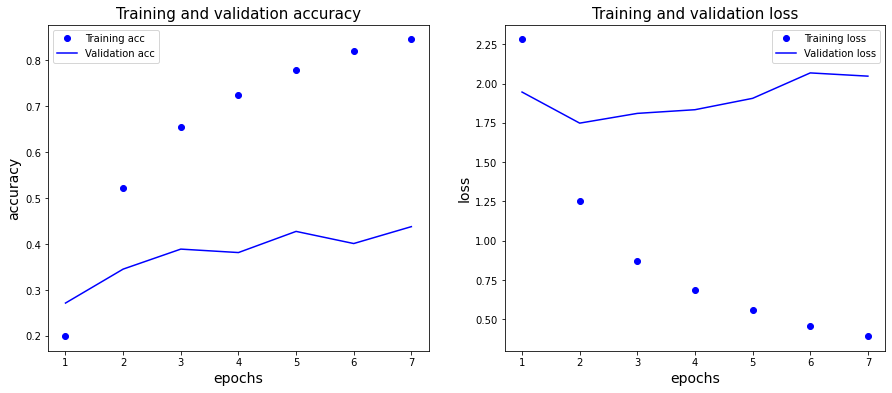

In [27]:
# Training and Validation accuracy 그림으로 확인
plot_loss_accuracy(history)

# 훈련된 모델을 이용해 예상 함수 만들기(Prediction)

In [28]:
# 이미지를 load 하고 생성하는 함수 정의
def load_and_prep_image(filename, img_shape=150, scale=True):

  # 이미지 읽기
    img = tf.io.read_file(filename)

  # 이미지 decode
    img = tf.io.decode_image(img, channels=3)

  # 이미지 사이즈 재조정
  # img = tf.image.resize(img, [img_shape, img_shape])
    img = tf.image.resize(img, list(IMAGE_SIZE))

  # 이미지 scaling
    if scale: # 이미지 크기 조정(0과 1 사이의 모든 값 가져오기)
        return img/255.
    else:
        return img # TensorFlow에서 EfficientNet 모델을 위해 이미지 크기를 조정할 필요 X

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sickmushrooms_sources2/sickmushrooms_sources/seg_pred/portobello1_12_18099107.jpg
sickmushrooms_sources2/sickmushrooms_sources/seg_pred/oyster1_13_16121498.jpg
sickmushrooms_sources2/sickmushrooms_sources/seg_pred/shiitake1_11_18585246.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


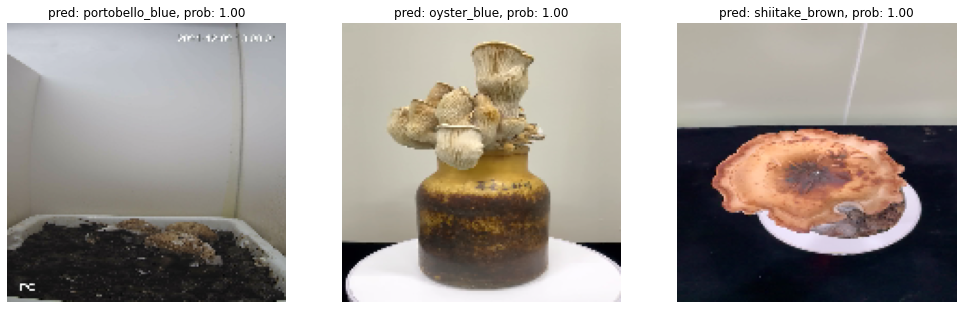

In [56]:
# pred 파일에서 무작위로 이미지 가져오기 
import os
import random

pred_dir="sickmushrooms_sources2/sickmushrooms_sources/seg_pred"
plt.figure(figsize=(17, 10))
for i in range(3): # random하게 이미지 가져오기
    filename = random.choice(os.listdir(pred_dir))
    filepath = pred_dir + "/" + filename
    print(filepath)
  
    # 이미지 load 및 예측
    img = load_and_prep_image(filepath, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)
    pred_prob = model.predict(img_expanded)
    pred_class = class_names[pred_prob.argmax()]
    
    plt.subplot(1, 3, i+1)
    plt.imshow(img/225.)
    plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
    plt.axis(False);

- 예측 - 양송이_푸른곰팡이병 /  느타리_푸른곰팡이병 / 표고_세균갈색무늬병
- 실제 - 양송이_푸른곰팡이병 / 느타리_푸른곰팡이병 /표고_푸른곰팡이병

# 예상 모델 정의 함수 만들기

In [42]:
def sickmushroom():

    import numpy as np
    from keras.preprocessing import image

    from tkinter import filedialog
    from tkinter import messagebox
    
    file_list = [] #파일 목록 담을 리스트 생성
    file = filedialog.askopenfilenames(initialdir="/",
                     title = "파일을 선택 해 주세요",
                        filetypes = (("*.jpg","*jpg"),("*.png","png"),("*.csv","*csv")))
    #files 변수에 선택 파일 경로 넣기

    if file == '':
        messagebox.showwarning("경고", "파일('jpg, png')을 추가 하세요") #파일 선택 안했을 때 메세지 출력

    file=''.join(file) 

    
    
    # 이미지 load 및 예측
    img = load_and_prep_image(file, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)
    pred_prob = model.predict(img_expanded)
    pred_class = class_names[pred_prob.argmax()]
    
    plt.figure(figsize=(6, 6))
#     plt.subplot(1, 3, i+1)
    plt.imshow(img/225.)
    plt.title(f"Predicted Mushroom and Disease : {pred_class}")
    plt.axis(False);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


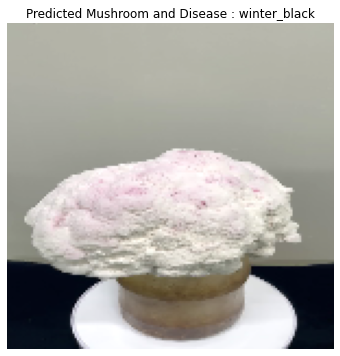

In [43]:
sickmushroom()

### winter1_1_16124693 사용 
### 예측 winter_black 
### 실제 winter_black 팽이버섯 세균성검은썩음병

# VGG16

In [32]:
# 사전 훈련된 모델 vgg16을 사용, VGG 네트워크 다운받기
# initializing convolutional base of vgg16
conv_base = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3)
                 )

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [33]:
# conv_base모델의 predict 메서드를 호출하여 이 이미지에서 특성을 추출
train_featuremap = conv_base.predict(trn_images_norm)
test_featuremap = conv_base.predict(tst_images_norm) 

In [34]:
# 차원확인 
train_featuremap.shape, test_featuremap.shape

((12000, 4, 4, 512), (2800, 4, 4, 512))

## 추출된 기능 위에 레이어 추가해 모델 훈련

In [35]:
model2 = models.Sequential()
model2.add(layers.Flatten(input_shape=(4,4,512)))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.4))
model2.add(layers.Dense(14, activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 14)                3598      
                                                                 
Total params: 2,101,006
Trainable params: 2,101,006
Non-trainable params: 0
_________________________________________________________________


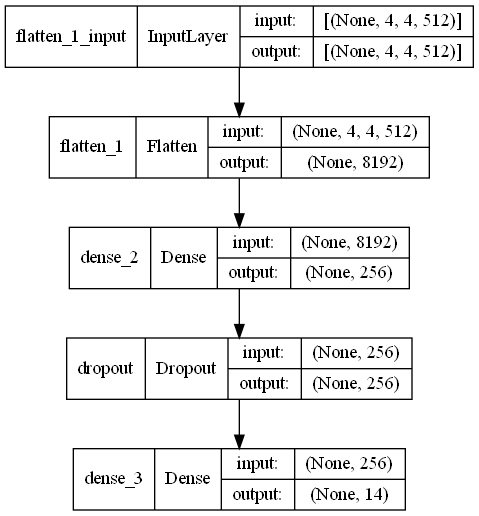

In [36]:
tf.keras.utils.plot_model(
    model2,
    to_file="model2.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [37]:
# optimizer에 RMSprop 사용
model2.compile(loss='categorical_crossentropy',
             optimizer= tf.keras.optimizers.RMSprop(learning_rate=2e-5),
             metrics=['accuracy']
             )


earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )

checkpointer = ModelCheckpoint(filepath='bestvalue', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

In [38]:
# model2 fit
result = model2.fit(train_featuremap, train_labels,
                   batch_size=256,
                   epochs=30,
                   validation_data=(test_featuremap, test_labels),
                   callbacks=callback_list
                   )

# loss 및 accuracy 확인
tst_loss, tst_acc = model2.evaluate(test_featuremap, test_labels, verbose=0)
print("Test loss and accuracy of model2:", tst_loss, tst_acc)

Epoch 1/30
47/47 [==============================] - 3s 46ms/step - loss: 2.3740 - accuracy: 0.2126 - val_loss: 2.1351 - val_accuracy: 0.2889
Epoch 2/30
47/47 [==============================] - 2s 41ms/step - loss: 1.8489 - accuracy: 0.4071 - val_loss: 1.8710 - val_accuracy: 0.3679
Epoch 3/30
47/47 [==============================] - 2s 43ms/step - loss: 1.5484 - accuracy: 0.4995 - val_loss: 1.7049 - val_accuracy: 0.3693
Epoch 4/30
47/47 [==============================] - 2s 42ms/step - loss: 1.3412 - accuracy: 0.5637 - val_loss: 1.5874 - val_accuracy: 0.3746
Epoch 5/30
47/47 [==============================] - 2s 40ms/step - loss: 1.1983 - accuracy: 0.6051 - val_loss: 1.5213 - val_accuracy: 0.4150
Epoch 6/30
47/47 [==============================] - 2s 46ms/step - loss: 1.0873 - accuracy: 0.6407 - val_loss: 1.4629 - val_accuracy: 0.4246
Epoch 7/30
47/47 [==============================] - 2s 43ms/step - loss: 0.9972 - accuracy: 0.6718 - val_loss: 1.4167 - val_accuracy: 0.4521
Epoch 8/30
47

In [39]:
# 모델저장
# model2.save("sickmushroom_classifier2.h5")

In [40]:
# from tensorflow.keras.models import load_model
# model2 = load_model('sickmushroom_classifier2.h5')

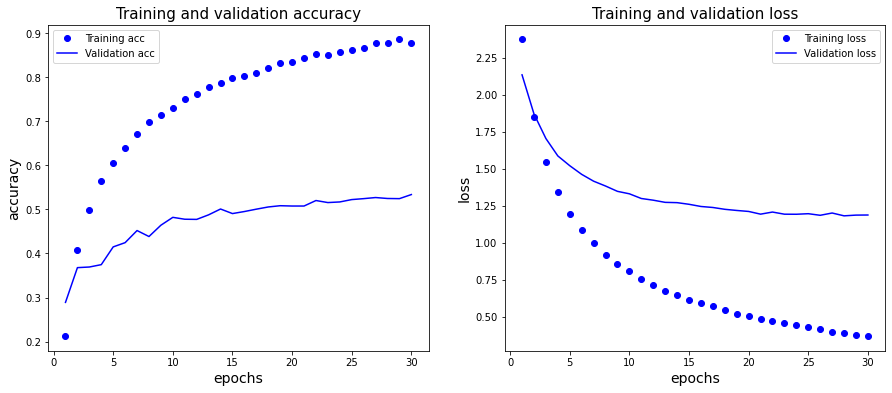

In [41]:
# loss 및 accuracy 시각화 
plot_loss_accuracy(result)

- 데이터 출처 : https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=480